### 데이터 수집 

In [2]:
# 패키지 
from bs4 import BeautifulSoup 
import time
import pandas as pd
import os
# selenium4
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import NoSuchElementException

In [3]:
# webdriver 객체생성
options = Options()

# 브라우저 꺼짐 방지 코드
options.add_experimental_option("detach", True)

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(options=options)
driver.implicitly_wait(2)


### 에누리페이지 접속

In [5]:
url = 'https://www.enuri.com/list.jsp?cate=050309'
driver.get(url)

### 상품 정보 가져오기

In [7]:
# 상품 리스트가 모두 로드될 때까지 대기
WebDriverWait(driver, 10).until(
    EC.presence_of_all_elements_located((By.CLASS_NAME, 'prodItem'))
)

# 상품 리스트 
goods = driver.find_elements(By.CLASS_NAME, 'prodItem')
# print(goods[0].text)


In [8]:
# 새 창 열기 / 닫기

# - driver: selenium webdriver 객체
# - link: 상품의 <a> 태그 
def open_detail(driver, link):
    # 현재 창 핸들 저장 
    original_window = driver.current_window_handle

    try:

        # 링크에서 href 주소 직접 추출 
        url = link.get_attribute('href')

        # 자바 스크립트로 새 탭에서 url 열기
        driver.execute_script(f'window.open("{url}","_blank");')
        
        # 새 창 열릴 때까지 대기 
        WebDriverWait(driver, 10).until(EC.number_of_windows_to_be(2))
    
        # 새 창으로 전환 
        for handle in driver.window_handles:
            if handle != original_window:
                driver.switch_to.window(handle)
                break
        
        # 로딩 대기 
        time.sleep(3)
    
        return original_window

    except Exception as e:
        print(f'새 창 열기 실패: {e}')
        return original_window

In [9]:
# 새 페이지에서 상품정보 크롤링

def crawl_detail(driver):
    result = {}
    name, price = None, None
       
    try:
        # 제품명 
        # prodinfo__tit 요소 나타날때까지 대기
        h2 = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'prodinfo__tit'))
        )
        
        
        # 전체 텍스트
        full_text = h2.text  
        
        try:
            # span태그 붙어있을 경우 삭제
            span_text = h2.find_element(By.TAG_NAME, 'span').text
            name = full_text.replace(span_text, '')
        except:
            name = full_text  # span 없으면 전체 텍스트 사용
        # print(name)

        # 가격 
        price = driver.find_element(By.CLASS_NAME, 'prodminprice__tx--price').find_element(By.TAG_NAME, 'strong').text

        # 상세정보
        
        # 상세정보 로드 대기 
        WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.ID, 'enuri_spec_table'))
        )
        
        html = driver.page_source  # Selenium에서 현재 페이지 소스 가져오기
        soup = BeautifulSoup(html, 'html.parser')

        # 상세정보 테이블에서 원하는 키만 추출 
        spec_table = soup.find('dl', id='enuri_spec_table')
        wanted_keys = ["흡입력(Pa)", "무게", "통과높이", "사용시간", "분당회전수" , "소음"]
        
        if spec_table:
            for th in spec_table.find_all('th'):
                key = th.get_text(strip=True)
                for wanted in wanted_keys:
                    if wanted in key:
                        td = th.find_next_sibling('td')
                        value = td.get_text(strip=True) if td else ""
                        result[wanted] = value

            
    except Exception as e:
            print('상세 페이지 크롤링 실패', e)
    
        
    return name, price, result


In [10]:
# 페이지 이동 
def next_page(driver, current_page):
    try:
        # 다음 페이지 번호 클릭 
        next_page_num = current_page + 1
        next_page_btn = driver.find_element(By.CSS_SELECTOR, f'a.paging__item[data-page="{next_page_num}"]')
        next_page_btn.click()
        time.sleep(3)
        return True
    except NoSuchElementException:
        # 다음 그룹버튼 클릭 
        try: 
            next_grp_btn = driver.find_element(By.CSS_SELECTOR, 'button.paging__btn--next')
            # 비활성화 상태면 마지막 페이지
            if 'is--desabled' in next_grp_btn.get_attribute('class'):
                return False
            next_grp_btn.click()
            time.sleep(3)
            return True
        except NoSuchElementException:
            # 둘다 없으면 마지막 페이지 
            return False
        

In [11]:
# 메인 루프 

items = [] # 상품 정보 담을 리스트
current_page = 1 # 현재 페이지 번호 
MAX_PAGE = 2 # 페이징 테스트용

while True:
    # 현재 페이지 크롤링 
    print(f'{current_page}페이지 크롤링 시작')
    
    for i in range(len(goods)):
        goods = driver.find_elements(By.CLASS_NAME, 'prodItem')
    
        link = goods[i].find_element(By.TAG_NAME,'a')
    
        # 새 창 열기 
        original_window = open_detail(driver, link)
    
        # 크롤링
        name, price, result = crawl_detail(driver)
        item = {"이름" : name, "가격" : price}
        item.update(result)
        items.append(item)
        print(item)
        
       
        driver.close() # 새 창 닫기 
        driver.switch_to.window(original_window) # 원래 창으로 복귀
        time.sleep(1)

    #테스트용 페이지 제한
    if current_page >= MAX_PAGE:
        break
    
    # 다음페이지로 이동
    if next_page(driver, current_page):
        current_page += 1
    else:
        print('마지막 페이지 - 크롤링 종료')
        break

# driver.quit()
    

1페이지 크롤링 시작
{'이름': '삼성전자 비스포크 스팀 VR7MD96516 ', '가격': '694,430', '흡입력(Pa)': '6,000', '무게': '4.8kg', '통과높이': '10cm', '사용시간': '3시간(최대)', '소음': '87dB'}
{'이름': '로보락 S9 MaxV Ultra ', '가격': '1,679,980', '흡입력(Pa)': '22,000', '무게': '4.6kg', '통과높이': '8cm', '사용시간': '3시간40분(최대)', '분당회전수': '4000회', '소음': '52dB'}
{'이름': '삼성전자 비스포크 AI 스팀 VR7MD97716 ', '가격': '1,096,410', '흡입력(Pa)': '6,000', '무게': '4.8kg', '통과높이': '10cm', '사용시간': '3시간(최대)', '소음': '65dB'}
{'이름': 'LG전자 오브제컬렉션 코드제로 로보킹 AI 올인원 B95AW ', '가격': '1,159,670', '흡입력(Pa)': '10,000', '무게': '4.13kg', '통과높이': '11cm', '사용시간': '1시간50분(최대)', '소음': '72dB'}
{'이름': '드리미 L10s Heat', '가격': '740,890', '흡입력(Pa)': '7,000', '통과높이': '10cm', '사용시간': '3시간40분(최대)', '소음': '62.3dB'}
{'이름': 'LG전자 코드제로 R5 R585WKA1 ', '가격': '500,330', '흡입력(Pa)': '2,700', '무게': '3.1kg', '통과높이': '10cm', '사용시간': '2시간20분(최대)'}
{'이름': '로보락 S8 Plus ', '가격': '884,480'}
{'이름': '에코백스 디봇 T30S 프로 DSX39 ', '가격': '759,790', '흡입력(Pa)': '11,000', '무게': '4.1kg', '통과높이': '11cm', '소음': '65dB'}
{'이름': '샤오미

In [7]:
# 파일로 저장
os.makedirs('./testData', exist_ok=True)

df = pd.DataFrame(items)
df

df.to_csv("./testData/robotic_vacuum_spec.csv", index=False, encoding="utf-8-sig")

NameError: name 'os' is not defined

In [13]:
items

[{'이름': '삼성전자 비스포크 스팀 VR7MD96516 ',
  '가격': '694,430',
  '흡입력(Pa)': '6,000',
  '무게': '4.8kg',
  '통과높이': '10cm',
  '사용시간': '3시간(최대)',
  '소음': '87dB'},
 {'이름': '로보락 S9 MaxV Ultra ',
  '가격': '1,679,980',
  '흡입력(Pa)': '22,000',
  '무게': '4.6kg',
  '통과높이': '8cm',
  '사용시간': '3시간40분(최대)',
  '분당회전수': '4000회',
  '소음': '52dB'},
 {'이름': '삼성전자 비스포크 AI 스팀 VR7MD97716 ',
  '가격': '1,096,410',
  '흡입력(Pa)': '6,000',
  '무게': '4.8kg',
  '통과높이': '10cm',
  '사용시간': '3시간(최대)',
  '소음': '65dB'},
 {'이름': 'LG전자 오브제컬렉션 코드제로 로보킹 AI 올인원 B95AW ',
  '가격': '1,159,670',
  '흡입력(Pa)': '10,000',
  '무게': '4.13kg',
  '통과높이': '11cm',
  '사용시간': '1시간50분(최대)',
  '소음': '72dB'},
 {'이름': '드리미 L10s Heat',
  '가격': '740,890',
  '흡입력(Pa)': '7,000',
  '통과높이': '10cm',
  '사용시간': '3시간40분(최대)',
  '소음': '62.3dB'},
 {'이름': 'LG전자 코드제로 R5 R585WKA1 ',
  '가격': '500,330',
  '흡입력(Pa)': '2,700',
  '무게': '3.1kg',
  '통과높이': '10cm',
  '사용시간': '2시간20분(최대)'},
 {'이름': '로보락 S8 Plus ', '가격': '884,480'},
 {'이름': '에코백스 디봇 T30S 프로 DSX39 ',
  '가격': '759,790',
  

In [9]:
import pandas as pd

df = pd.read_csv('robotic_vacuum_spec.csv', encoding='utf-8')

df

,이름,가격,흡입력(Pa),무게,통과높이,사용시간,소음,분당회전수
0,삼성전자 비스포크 스팀 VR7MD96516,"694,740","6,000",4.8kg,10cm,3시간(최대),87dB,NaN
1,로보락 S9 MaxV Ultra,"1,681,490","22,000",4.6kg,8cm,3시간40분(최대),52dB,4000회
2,삼성전자 비스포크 AI 스팀 VR7MD97716,"1,060,570","6,000",4.8kg,10cm,3시간(최대),65dB,NaN
3,LG전자 오브제컬렉션 코드제로 로보킹 AI 올인원 B95AW,"1,153,270","10,000",4.13kg,11cm,1시간50분(최대),72dB,NaN
4,드리미 L10s Heat,"740,930","7,000",NaN,10cm,3시간40분(최대),62.3dB,NaN
...,...,...,...,...,...,...,...,...
75,드리미 S20 Ultra,"689,000","8,300",4kg,11cm,4시간(최대),NaN,"4,050회"
76,샤오미 미홀 C66S,"70,030","3,400",NaN,9.5cm,NaN,NaN,NaN
77,로보락 Q Revo Curv,"1,487,000","18,500",NaN,11cm,NaN,NaN,NaN
78,샤오미 미지아 M40,"491,470","12,000",4.2kg,10cm,2시간10분(최대),NaN,NaN


In [15]:
# 이름이 빈 셀 삭제 
df.dropna(subset=['이름'], inplace=True)

# 인덱스 초기화
df.reset_index(drop=True, inplace=True)

# 변경 후 데이터 정보
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   이름       79 non-null     object
 1   가격       79 non-null     object
 2   흡입력(Pa)  69 non-null     object
 3   무게       58 non-null     object
 4   통과높이     73 non-null     object
 5   사용시간     53 non-null     object
 6   소음       41 non-null     object
 7   분당회전수    6 non-null      object
dtypes: object(8)
memory usage: 5.1+ KB


In [17]:
# 회사명 , 모델명 분리
company_list = []
product_list = []

for name in df['이름']:
    if type(name) != str: continue

    name_info = name.split(' ',1)
    # print(name_info)
    # print(len(name_info))
    if len(name_info) == 1:
        company_name = name_info[0]
        product_name = name_info[0]
    else:
        company_name = name_info[0]
        product_name = name_info[1]
    # print(company_name, product_name)
    company_list.append(company_name)
    product_list.append(product_name)

print(len(company_list))
print(len(product_list))

df['회사명'] = company_list
df['모델명'] = product_list

df


79
79


,이름,가격,흡입력(Pa),무게,통과높이,사용시간,소음,분당회전수,회사명,모델명
0,삼성전자 비스포크 스팀 VR7MD96516,"694,740","6,000",4.8kg,10cm,3시간(최대),87dB,NaN,삼성전자,비스포크 스팀 VR7MD96516
1,로보락 S9 MaxV Ultra,"1,681,490","22,000",4.6kg,8cm,3시간40분(최대),52dB,4000회,로보락,S9 MaxV Ultra
2,삼성전자 비스포크 AI 스팀 VR7MD97716,"1,060,570","6,000",4.8kg,10cm,3시간(최대),65dB,NaN,삼성전자,비스포크 AI 스팀 VR7MD97716
3,LG전자 오브제컬렉션 코드제로 로보킹 AI 올인원 B95AW,"1,153,270","10,000",4.13kg,11cm,1시간50분(최대),72dB,NaN,LG전자,오브제컬렉션 코드제로 로보킹 AI 올인원 B95AW
4,드리미 L10s Heat,"740,930","7,000",NaN,10cm,3시간40분(최대),62.3dB,NaN,드리미,L10s Heat
...,...,...,...,...,...,...,...,...,...,...
74,드리미 S20 Ultra,"689,000","8,300",4kg,11cm,4시간(최대),NaN,"4,050회",드리미,S20 Ultra
75,샤오미 미홀 C66S,"70,030","3,400",NaN,9.5cm,NaN,NaN,NaN,샤오미,미홀 C66S
76,로보락 Q Revo Curv,"1,487,000","18,500",NaN,11cm,NaN,NaN,NaN,로보락,Q Revo Curv
77,샤오미 미지아 M40,"491,470","12,000",4.2kg,10cm,2시간10분(최대),NaN,NaN,샤오미,미지아 M40


In [19]:
# '(최대)' 삭제 
use_time = df['사용시간'].str.replace('(최대)','',regex=False)
use_time.head()

0       3시간
1    3시간40분
2       3시간
3    1시간50분
4    3시간40분
Name: 사용시간, dtype: object

In [21]:

# type(df['가격'][0])
# 예제 6-25 연속시간을 분 단위로 조정하는 함수
def convert_time_minute(time):
    try:
        if '시간' in time:
            hour = time.split('시간')[0]
            if '분' in time:
                minute = time.split('시간')[-1].split('분')[0]
            else:
                minute = 0
        else: 
            hour = 0
            minute = time.split('분')[0]
        return int(hour)*60 + int(minute)
    except:
        return None   


In [23]:
# 예제 6-26 연속시간을 분 단위로 조정하는 함수의 테스트
times = ["40분", "4분", "1시간", "3시간30분", "4시간"]
for time in times:
    time_value = convert_time_minute(time)
    print(time, "=", time_value)

40분 = 40
4분 = 4
1시간 = 60
3시간30분 = 210
4시간 = 240


In [25]:
# 함수 적용 
new_use_time = []
for time in use_time:
    value = convert_time_minute(time)
    new_use_time.append(value)

new_use_time[:5]

[180, 220, 180, 110, 220]

In [27]:
df['사용시간'] = new_use_time
df['사용시간']

0     180.0
1     220.0
2     180.0
3     110.0
4     220.0
      ...  
74    240.0
75      NaN
76      NaN
77    130.0
78     20.0
Name: 사용시간, Length: 79, dtype: float64

In [15]:
#무게	통과높이	사용시간	소음	분당회전수 ( 단위 제거 ) 

#가격 흡입력 string 값 number로 변환 

#이름 에 <브랜드랑 제품명 > 나누기 
 
# +> 추가적으로 결측치 제거할떄마다 변수에 담아서 완전한 클린값들을 정제해서 저장 

In [31]:
df_raw = df.copy()

# df_clean1 사본을 만들기 
df_clean1 = df_raw.copy()

#1 무게 값 => float  
df_clean1['무게'] = df_clean1['무게'].str.replace('kg', '')

# 숫자로 못 바꾸는 값은 NaN으로 처리
df_clean1['무게'] = pd.to_numeric(df_clean1['무게'], errors='coerce')

#2 통과 높이 => float 
df_clean1['통과높이'] = df_clean1['통과높이'].str.replace('cm', '')
df_clean1['통과높이'] = pd.to_numeric(df_clean1['통과높이'], errors='coerce')

#3 분당회전수  => int
df_clean1['분당회전수'] = df_clean1['분당회전수'].str.replace('회', '')
df_clean1['분당회전수'] = pd.to_numeric(df_clean1['분당회전수'], errors='coerce')

#print(df_clean1[['무게', '통과높이' , '분당회전수']])

df_clean1[['무게' , '통과높이' , '분당회전수']].info()

#print("결측치 수:",df_clean1[['무게', '통과높이' , '분당회전수']].isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   무게      58 non-null     float64
 1   통과높이    73 non-null     float64
 2   분당회전수   5 non-null      float64
dtypes: float64(3)
memory usage: 2.0 KB


In [33]:
df_clean1['가격'] = df_clean1['가격'].str.replace(',', '')      # 쉼표 제거
df_clean1['가격'] = df_clean1['가격'].str.strip()               # 앞뒤 공백 제거
df_clean1['가격'] = df_clean1['가격'].astype(float)
df_clean1['흡입력(Pa)'] = (
    df_clean1['흡입력(Pa)']
    .str.replace(',', '')      # 쉼표 제거
    .str.strip()               # 앞뒤 공백 제거
    .str.replace('Pa', '')
    .astype(float)
)

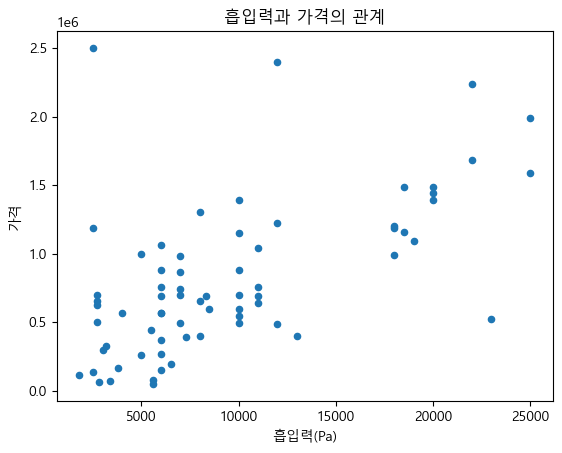

In [35]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows의 '맑은 고딕'
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

x = '흡입력(Pa)'
y = '가격'

# x나 y가 NaN인 행 제거
df_clean1 = df_clean1.dropna(subset=[x, y])

df_clean1.plot(kind='scatter', x='흡입력(Pa)', y='가격')
plt.title('흡입력과 가격의 관계')
plt.xlabel('흡입력(Pa)')
plt.ylabel('가격')
plt.show()

In [37]:
print(df_clean1[['흡입력(Pa)','가격']].corr())

          흡입력(Pa)        가격
흡입력(Pa)  1.000000  0.587048
가격       0.587048  1.000000


In [39]:
print(df_clean1[['사용시간','가격']].corr())

          사용시간        가격
사용시간  1.000000  0.166107
가격    0.166107  1.000000


In [47]:
print(df_clean1[['무게','가격']].corr())

          무게        가격
무게  1.000000  0.484715
가격  0.484715  1.000000


In [45]:
df['무게'].dropna()

0      4.8kg
1      4.6kg
2      4.8kg
3     4.13kg
5      3.1kg
6      4.7kg
7      4.1kg
8     3.75kg
9     4.53kg
11    4.13kg
12     4.5kg
13     4.7kg
14    4.95kg
15     4.1kg
16     4.9kg
17     4.5kg
18     4.7kg
19     4.5kg
21    4.23kg
23     3.5kg
24       4kg
25     4.1kg
26     4.1kg
27     3.4kg
28     3.1kg
29     3.2kg
30       3kg
32     3.9kg
33    1.45kg
34     2.3kg
35     3.1kg
36     3.7kg
37     3.8kg
38       4kg
39     4.5kg
40     5.3kg
45    2.05kg
46     3.6kg
49     1.3kg
50     4.8kg
55    3.67kg
56     1.3kg
57     4.5kg
60       1kg
61    1.15kg
62     3.4kg
63     6.7kg
65    3.57kg
66    3.23kg
67       4kg
68     3.4kg
69     3.1kg
70       5kg
71    3.21kg
73     3.9kg
74       4kg
77     4.2kg
78    1.05kg
Name: 무게, dtype: object